# Basic stats using `Scipy`
In this example we will go over how to draw samples from various built in probability distributions and define your own custom distributions.

## Packages being used
+ `scipy`: has all the stats stuff
+ `numpy`: has all the array stuff

## Relevant documentation
+ `scipy.stats`: http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html, http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous, http://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats

In [2]:
import numpy as np
import scipy.stats as st
# some special functions we will make use of later on
from scipy.special import erfc
from matplotlib import pyplot as plt
from astropy.visualization import hist
import mpl_style
%matplotlib inline
plt.style.use('default')
plt.style.use(mpl_style.style1)

There are many probability distributions that are already available in `scipy`: http://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats.  These classes allow for the evaluations of PDFs, CDFs, PPFs, moments, random draws, and fitting.  As an example lets take a look at the normal distribution.

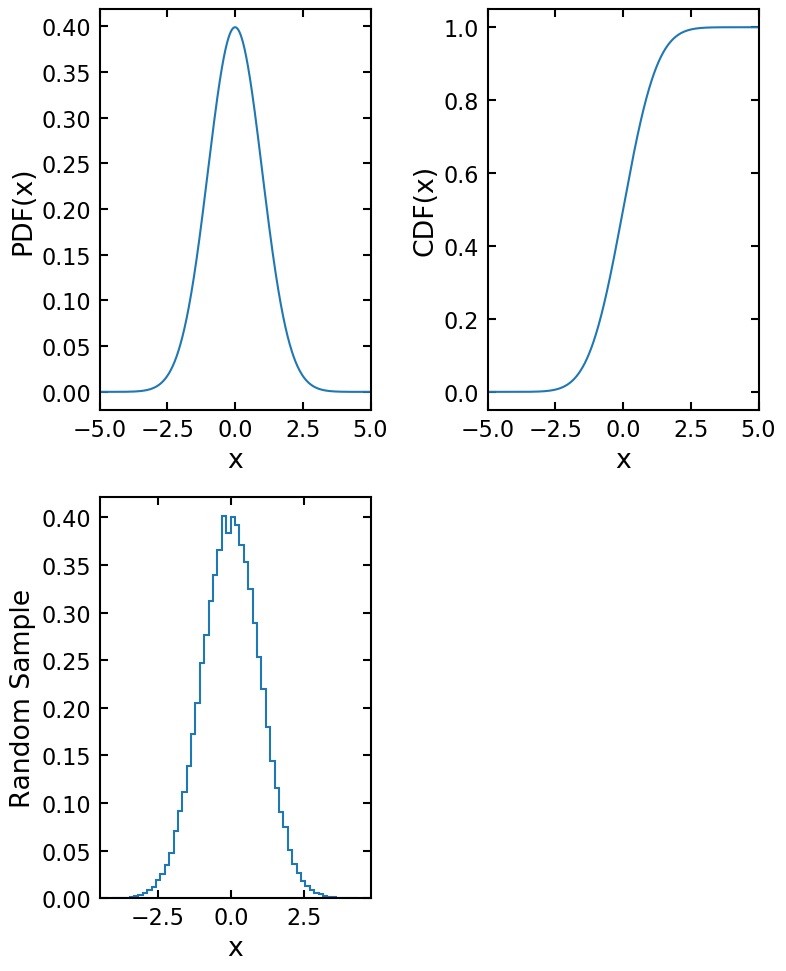

In [3]:
norm = st.norm(loc=0, scale=1)
x = np.linspace(-5, 5, 1000)
plt.figure(1, figsize=(8, 10))
plt.subplot2grid((2, 2), (0, 0))
plt.plot(x, norm.pdf(x))
plt.xlabel('x')
plt.ylabel('PDF(x)')
plt.xlim(-5, 5)
plt.subplot2grid((2, 2), (0, 1))
plt.plot(x, norm.cdf(x))
plt.xlabel('x')
plt.ylabel('CDF(x)')
plt.xlim(-5, 5)
plt.subplot2grid((2, 2), (1, 0))
sample_norm = norm.rvs(size=100000)
hist(sample_norm, bins='knuth', histtype='step', lw=1.5, density=True)
plt.xlabel('x')
plt.ylabel('Random Sample')
plt.tight_layout()

You can calculate moments and fit data:

In [4]:
for i in range(4):
    print('moment {0}: {1}'.format(i+1, norm.moment(i+1)))

print('best fit: {0}'.format(st.norm.fit(sample_norm)))

moment 1: 0.0
moment 2: 1.0
moment 3: 0.0
moment 4: 3.0
best fit: (-0.0012332358901274972, 0.9975667586725817)


# Custom probability distributions
Sometimes you need to use obscure PDFs that are not already in `scipy` or `astropy`.  When this is the case you can make your own subclass of `st.rv_continuous` and overwrite the `_pdf` or `_cdf` methods.  This new sub class will act exactly like the built in distributions.

The methods you can override in the subclass are:

+ \_rvs: create a random sample drawn from the distribution
+ \_pdf: calculate the PDF at any point
+ \_cdf: calculate the CDF at any point
+ \_sf: survival function, a.k.a. 1-CDF(x)
+ \_ppf: percent point function, a.k.a. inverse CDF
+ \_isf: inverse survival function
+ \_stats: function that calculates the first 4 moments
+ \_munp: function that calculates the nth moment
+ \_entropy: differential entropy
+ \_argcheck: function to check the input arguments are valid (e.g. var>0)

You should override any method you have analytic functions for, otherwise (typically slow) numerical integration, differentiation, and function inversion are used to transform the ones that are specified.

## The exponentially modified Gaussian distribution
As and example lets create a class for the EMG distribution (https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution).  This is the distributions resulting from the sum of a Gaussian random variable and an exponential random variable.  The PDF and CDF are:

\begin{align}
f(x;\mu,\sigma, \lambda) & = \frac{\lambda}{2} \exp{\left( \frac{\lambda}{2} \left[ 2\mu+\lambda\sigma^{2}-2x \right] \right)} \operatorname{erfc}{\left( \frac{\mu + \lambda\sigma^{2}-x}{\sigma\sqrt{2}} \right)} \\
F(x; \mu, \sigma, \lambda) & = \Phi(u, 0, v) - \Phi(u, v^2, v) \exp{\left( -u + \frac{v^2}{2} \right)} \\
\Phi(x, a, b) & = \frac{1}{2} \left[ 1 + \operatorname{erf}{\left( \frac{x - a}{b\sqrt{2}} \right)} \right] \\
u & = \lambda(x - \mu) \\
v & = \lambda\sigma
\end{align}

In [5]:
# create a generating class
class EMG_gen1(st.rv_continuous):
    def _pdf(self, x, mu, sig, lam):
        u = 0.5 * lam * (2 * mu + lam * sig**2 - 2 * x)
        v = (mu + lam * sig**2 - x)/(sig * np.sqrt(2))
        return 0.5 * lam * np.exp(u) * erfc(v)
    def _cdf(self, x, mu, sig, lam):
        u = lam * (x - mu)
        v = lam * sig
        phi1 = st.norm.cdf(u, loc=0, scale=v)
        phi2 = st.norm.cdf(u, loc=v**2, scale=v)
        return phi1 - phi2 * np.exp(-u + 0.5 * v**2)
    def _stats(self, mu, sig, lam):
        # reutrn the mean, variance, skewness, and kurtosis
        mean = mu + 1 / lam
        var = sig**2 + 1 / lam**2
        sl = sig * lam
        u = 1 + 1 / sl**2
        skew = (2 / sl**3) * u**(-3 / 2)
        v = 3 * (1 + 2 / sl**2 + 3 / sl**4) / u**2
        kurt = v - 3
        return mean, var, skew, kurt
    def _argcheck(self, mu, sig, lam):
        return np.isfinite(mu) and (sig > 0) and (lam > 0)

class EMG_gen2(EMG_gen1):
    def _ppf(self, q, mu, sig, lam):
        # use linear interpolation to solve this faster (not exact, but much faster than the built in method)
        # pick range large enough to fit the full cdf
        var = sig**2 + 1 / lam**2
        x = np.arange(mu - 50 * np.sqrt(var), mu + 50 * np.sqrt(var), 0.01)
        y = self.cdf(x, mu, sig, lam)
        return np.interp(q, y, x)

class EMG_gen3(EMG_gen1):
    def _rvs(self, mu, sig, lam):
        # redefine the random sampler to sample based on a normal and exp dist
        return st.norm.rvs(loc=mu, scale=sig, size=self._size) + st.expon.rvs(loc=0, scale=1/lam, size=self._size)

# use generator to make the new class
EMG1 = EMG_gen1(name='EMG1')
EMG2 = EMG_gen2(name='EMG2')
EMG3 = EMG_gen3(name='EMG3')

Lets look at how long it takes to create readom samples for each of these version of the EMG:

In [6]:
%time EMG1.rvs(0, 1, 0.5, size=1000)
print('=========')
%time EMG2.rvs(0, 1, 0.5, size=1000)
print('=========')
%time EMG3.rvs(0, 1, 0.5, size=1000)
print('=========')

CPU times: user 8.49 s, sys: 61.2 ms, total: 8.55 s
Wall time: 9.54 s
CPU times: user 7.22 ms, sys: 3.25 ms, total: 10.5 ms
Wall time: 11.7 ms
CPU times: user 1.1 ms, sys: 130 µs, total: 1.23 ms
Wall time: 1.34 ms


As you can see, the numerical inversion of the CDF is very slow, the approximation to the inversion is much faster, and defining `_rvs` in terms of the `normal` and `exp` distributions is the fastest.

Lets take a look at the results for `EMG3`:

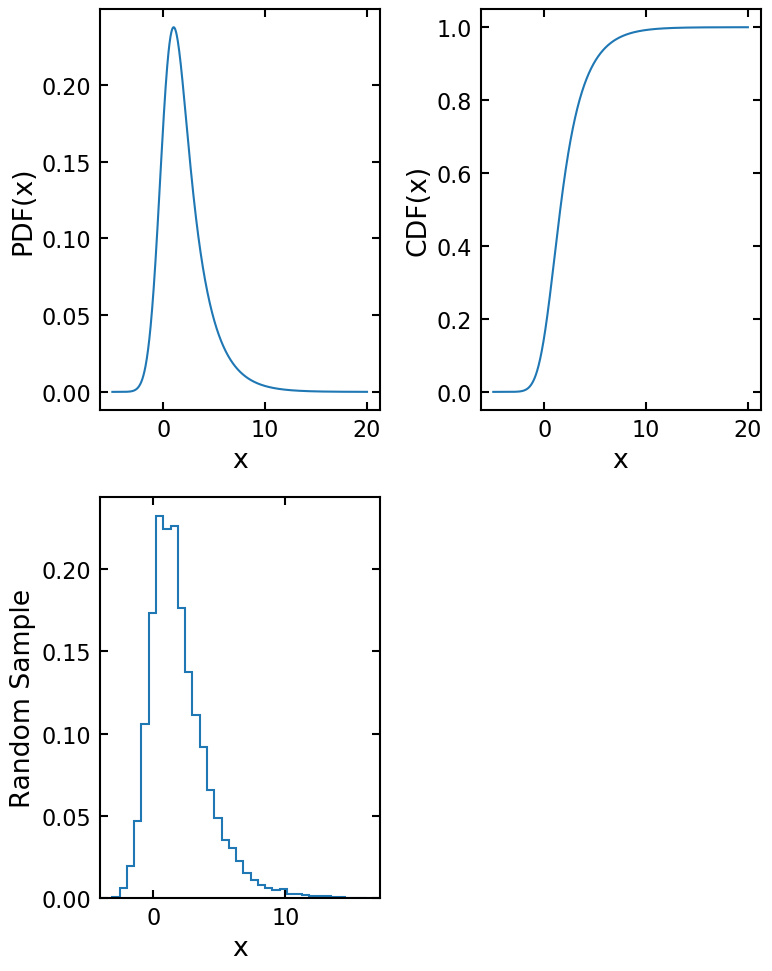

In [7]:
dist = EMG3(0, 1, 0.5)
x = np.linspace(-5, 20, 1000)
plt.figure(2, figsize=(8, 10))
plt.subplot2grid((2, 2), (0, 0))
plt.plot(x, dist.pdf(x))
plt.xlabel('x')
plt.ylabel('PDF(x)')
plt.subplot2grid((2, 2), (0, 1))
plt.plot(x, dist.cdf(x))
plt.xlabel('x')
plt.ylabel('CDF(x)')
plt.subplot2grid((2, 2), (1, 0))
sample_emg = dist.rvs(size=10000)
hist(sample_emg, bins='knuth', histtype='step', lw=1.5, density=True)
plt.xlabel('x')
plt.ylabel('Random Sample')
plt.tight_layout()

As with the built in functions we can calculate moments and do fits to data.  **Note** Since we are not using the built in `loc` and `scale` params they are fixed to 0 and 1 in the fit below.

In [8]:
for i in range(4):
    print('moment {0}: {1}'.format(i+1, dist.moment(i+1)))

print('best fit: {0}'.format(EMG3.fit(sample_emg, floc=0, fscale=1)))

moment 1: 2.0
moment 2: 9.0
moment 3: 54.0
moment 4: 435.0
best fit: (-0.025441047775655215, 0.9875431617248385, 0.5018381039808805, 0, 1)


For reference here is how `scipy` defines this distribution (found under the name `exponnorm`):

In [9]:
import scipy.stats._continuous_distns as cd
np.source(cd.exponnorm_gen)

In file: /Users/coleman/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py

class exponnorm_gen(rv_continuous):
    r"""An exponentially modified Normal continuous random variable.

    %(before_notes)s

    Notes
    -----
    The probability density function for `exponnorm` is:

    .. math::

        f(x, K) = \frac{1}{2K} \exp\left(\frac{1}{2 K^2} - x / K \right)
                  \text{erfc}\left(-\frac{x - 1/K}{\sqrt{2}}\right)

    where :math:`x` is a real number and :math:`K > 0`.

    It can be thought of as the sum of a standard normal random variable
    and an independent exponentially distributed random variable with rate
    ``1/K``.

    %(after_notes)s

    An alternative parameterization of this distribution (for example, in
    `Wikipedia <https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution>`_)
    involves three parameters, :math:`\mu`, :math:`\lambda` and
    :math:`\sigma`.
    In the present parameterization this corres

In [12]:
%time st.exponnorm.rvs(0.5, size=1000)
print('=========')

CPU times: user 765 µs, sys: 326 µs, total: 1.09 ms
Wall time: 966 µs
